In [70]:
from sklearn.model_selection import GridSearchCV
from pandas import read_csv
from sklearn import svm
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

## Read Data

In [71]:
# Read data
train_data = pd.read_csv("/Users/alex/Desktop/data/5_train_dataset.csv")
X_train = train_data.drop('is_fraud', axis=1)
y_train = train_data['is_fraud']

test_data = pd.read_csv("/Users/alex/Desktop/data/4_test_dataset.csv")
X_test = test_data.drop('is_fraud', axis=1)
y_test = test_data['is_fraud']

## Training LightGBM model

In [72]:
def train_model_lgb(X_train,y_train, lgb_model):

    # model parameters
    param_grid = {
        'num_leaves': [20, 30, 40],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [50, 100, 150],
    }

    # perform grid search for hyperparameter tuning
    grid_search = GridSearchCV(
        lgb_model,
        param_grid,
        cv=3,
        n_jobs=-1
    )

     # fit the grid search on the training data
    grid_search.fit(X_train, y_train)

    # get the best hyperparameters
    best_params = grid_search.best_params_

    # print the best hyperparameters found
    print("Best Hyperparameters:", best_params)

    # set the best hyperparameters to the model
    lgb_model.set_params(**best_params)

    # train the final LightGBM model on the entire training set
    lgb_model.fit(X_train, y_train)




In [88]:
def evaluate_model(model, predX, predY):

    y_pred = model.predict(predX)

    # accuracy
    acc =  accuracy_score(predY, y_pred)
    print("Accuracy: %.2f%%" % (acc * 100))

    # precision
    precision = precision_score(predY, y_pred)
    print("Precision: %.2f%%" % (precision* 100))

    # recall
    recall = recall_score(predY, y_pred)
    print("Recall: %.2f%%" % (recall*100))

    # f1 Score
    f1 = f1_score(predY, y_pred)
    print("F1 Score: %.2f%%" % (f1*100))

    # ROC-AUC score
    roc_auc = roc_auc_score(predY, y_pred)
    print("ROC-AUC Score: %.2f%%" % (roc_auc*100))


In [74]:

# create the LightGBM model
lgb_model = lgb.LGBMClassifier()

# train model
train_model_lgb(X_train,y_train, lgb_model)


[LightGBM] [Info] Number of positive: 872, number of negative: 3054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3877
[LightGBM] [Info] Number of data points in the train set: 3926, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222109 -> initscore=-1.253418
[LightGBM] [Info] Start training from score -1.253418
[LightGBM] [Info] Number of positive: 872, number of negative: 3054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3877
[LightGBM] [Info] Number of data points in the train set: 3926, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222109 -> initscore=-1.253418
[LightGBM]

In [89]:
evaluate_model(lgb_model,X_test, y_test)

Accuracy: 97.53%
Precision: 97.66%
Recall: 91.06%
F1 Score: 94.24%
ROC-AUC Score: 95.22%


## Permutation Importance 

In [76]:
r = permutation_importance(lgb_model, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [77]:
# Get permutation importances
importances = r.importances_mean

# Create a DataFrame to display feature importances
permutation_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Permutation_Importance_Mean': importances,
})

# Rank features based on importances mean value in descending order
ranked_features = permutation_importance_df.sort_values(by='Permutation_Importance_Mean', ascending=False)

# Display the ranked features
print("Ranked Features based on Permutation Importance Mean:")
print(ranked_features)

Ranked Features based on Permutation Importance Mean:
                                     Feature  Permutation_Importance_Mean
14                            has_sent_ERC20                     0.176173
7       ERC20_num_unique_recipients_from_acc                     0.055250
8                  num_unique_senders_to_acc                     0.023996
10                      total_ether_received                     0.018954
12             first_and_last_txns_time_diff                     0.015678
1                         total_transactions                     0.015338
0            ERC20_num_unique_senders_to_acc                     0.013488
6                             min_value_sent                     0.007291
5           num_received_to_total_txns_ratio                     0.005280
18                avg_time_between_sent_txns                     0.004694
17                        min_value_received                     0.004083
16            avg_time_between_received_txns              

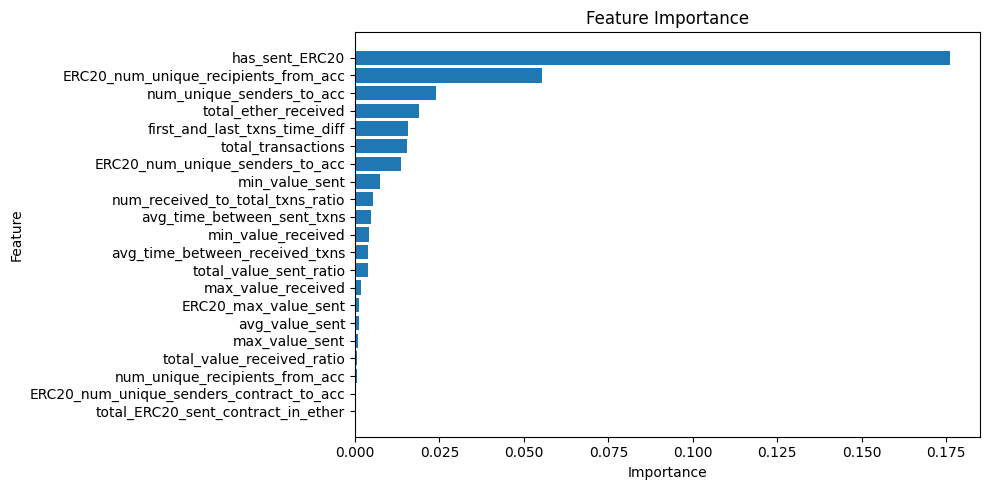

In [82]:
plt.figure(figsize=(10, 5))
plt.style.use('default')
plt.barh(ranked_features['Feature'], ranked_features['Permutation_Importance_Mean'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Built-in Feature Importance

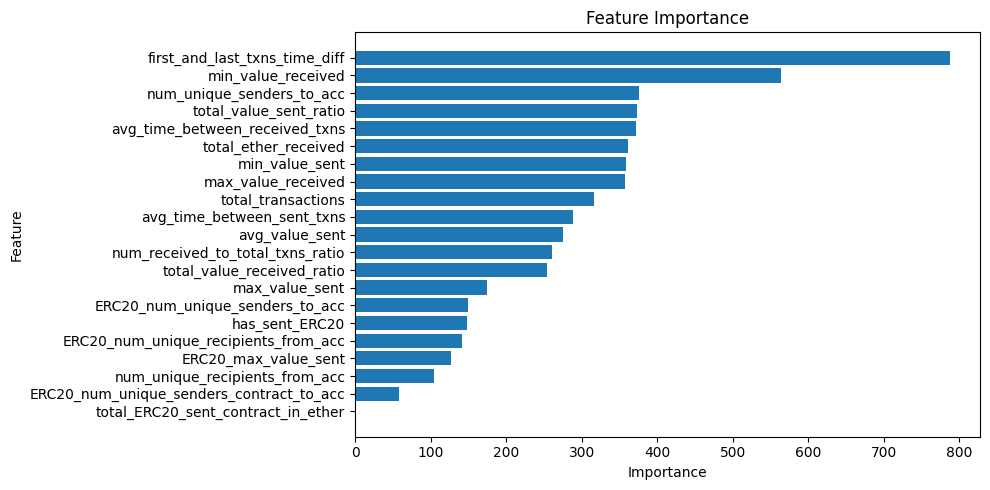

In [84]:
# Extract feature importance
feature_importance = lgb_model.feature_importances_

# Display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': feature_importance
})

# Sort features by importance


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending= False)

# Plotting the horizontal bar chart with adjusted scale
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()